In [1]:
import datetime
import time
import numpy as np
from timor.Geometry import Box, ComposedGeometry, Cylinder
from timor.task.Obstacle import Obstacle
from timor.task.Task import Task, TaskHeader
from timor.utilities.transformation import Transformation
from timor.utilities.spatial import rotX, rotY, rotZ

2024-11-12 21:43:41,304 Timor INFO Loading custom configurations from /home/mscsim/.config/timor.config


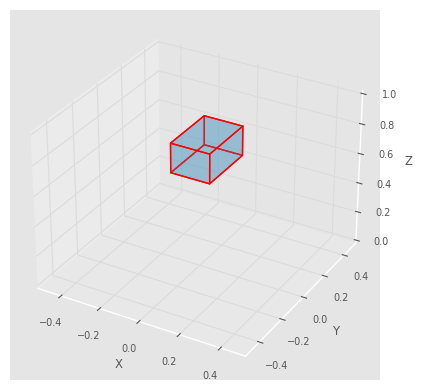

[{'size': {'x': 0.2, 'y': 0.3, 'z': 0.2}, 'origin': {'x': -0.20453227388597817, 'y': 0.09488916342053644, 'z': 0.4753143039917406}}]


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Function to generate cuboid vertices
def cuboid_data(origin, size):
    x = [origin[0], origin[0] + size[0]]
    y = [origin[1], origin[1] + size[1]]
    z = [origin[2], origin[2] + size[2]]
    return np.array([[x[0], y[0], z[0]],
                    [x[1], y[0], z[0]],
                    [x[1], y[1], z[0]],
                    [x[0], y[1], z[0]],
                    [x[0], y[0], z[1]],
                    [x[1], y[0], z[1]],
                    [x[1], y[1], z[1]],
                    [x[0], y[1], z[1]]])

# Function to plot cuboid
def plot_cuboid(ax, cuboid):
    vertices = [[cuboid[0], cuboid[1], cuboid[2], cuboid[3]],
                [cuboid[4], cuboid[5], cuboid[6], cuboid[7]],
                [cuboid[0], cuboid[1], cuboid[5], cuboid[4]],
                [cuboid[2], cuboid[3], cuboid[7], cuboid[6]],
                [cuboid[1], cuboid[2], cuboid[6], cuboid[5]],
                [cuboid[4], cuboid[7], cuboid[3], cuboid[0]]]

    faces = Poly3DCollection(vertices, linewidths=1, edgecolors='r', alpha=.25)
    ax.add_collection3d(faces)

# Function to check for overlap between two cuboids using their axis-aligned bounding boxes (AABB)
def check_overlap(cub1_min, cub1_max, cub2_min, cub2_max):
    return not (cub1_max[0] <= cub2_min[0] or cub1_min[0] >= cub2_max[0] or
                cub1_max[1] <= cub2_min[1] or cub1_min[1] >= cub2_max[1] or
                cub1_max[2] <= cub2_min[2] or cub1_min[2] >= cub2_max[2])

# Random cuboid volume generation
def random_cuboid_volume(total_volume, num_cuboids):
    volumes = np.random.rand(num_cuboids)
    volumes = volumes / np.sum(volumes) * total_volume
    return volumes

# Function to generate cuboid size, ensuring it fits within the space and respects a maximum size
def generate_random_cuboid(vol, max_size, space_size=(1.0, 1.0, 1.0)):
    dims = np.random.rand(3)
    dims = dims / np.prod(dims) * vol
    dims = np.cbrt(dims)
    dims = np.minimum(dims, max_size)
    dims = np.minimum(dims, space_size)
    return dims

# Plot cuboids and ensure no overlap
def plot_random_cuboids(num_cuboids=20, total_volume=0.001, space_size=(1.0, 1.0, 1.0), max_size=(0.5, 0.5, 0.5)):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    cuboids = []
    volumes = random_cuboid_volume(total_volume, num_cuboids)
    attempts = 0
    cuboid_info = []

    x_bounds = (-0.5, 0.5)
    y_bounds = (-0.5, 0.5)
    z_bounds = (0, 1.0)

    while len(cuboids) < num_cuboids and attempts < 10000:
        vol = volumes[len(cuboids)]
        dims = generate_random_cuboid(vol, max_size, space_size)

        # Generate random position within the defined space boundaries
        origin = np.array([np.random.uniform(x_bounds[0], x_bounds[1] - dims[0]),
                        np.random.uniform(y_bounds[0], y_bounds[1] - dims[1]),
                        np.random.uniform(z_bounds[0], z_bounds[1] - dims[2])])

        cub_min = origin
        cub_max = origin + dims

        if all(not check_overlap(cub_min, cub_max, cub[0], cub[1]) for cub in cuboids):
            cuboids.append((cub_min, cub_max))
            cuboid = cuboid_data(cub_min, dims)
            plot_cuboid(ax, cuboid)
            cuboid_info.append({
                'size': {'x': float(dims[0]), 'y': float(dims[1]), 'z': float(dims[2])},
                'origin': {'x': float(origin[0]), 'y': float(origin[1]), 'z': float(origin[2])}
            })
        attempts += 1
        if attempts >= 10000:
            print("Maximum number of attempts reached. Could not place all cuboids without overlap.")
            break

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim(x_bounds)
    ax.set_ylim(y_bounds)
    ax.set_zlim(z_bounds)
    plt.show()

    return cuboid_info

# Plot the cuboids with a maximum size of 0.2 in x, 0.3 in y, and 0.2 in z dimensions
cuboid_data_list = plot_random_cuboids(num_cuboids=1, total_volume=0.2, max_size=(0.2, 0.3, 0.2))

# Print the sizes and origins
print(cuboid_data_list[:5])


In [6]:
header = TaskHeader(
    ID='Random Obstacles Generation',
    tags=['Capstone', 'demo'],
    date=datetime.datetime(2024, 10, 28),
    author=['Jonas Li'],
    email=['liyunzhe.jonas@berkeley.edu'],
    affiliation=['UC Berkeley']
)

box = []
for idx, info in enumerate(cuboid_data_list):
    size, displacement = info["size"], info["origin"]
    box.append(Obstacle(ID=str(idx), 
                 collision=Box(
                     dict(x=size['x'], y=size['y'], z=size['z']),  # Size
                     pose=Transformation.from_translation([displacement['x'], displacement['y'], displacement['z']])
                          @ Transformation.from_rotation(rotY(2*np.pi)[:3, :3]))))# Displacement
print(len(box))
task = Task(header, obstacles=[i for i in box])

1


In [7]:
task.visualize()

2024-11-12 21:44:51,203 Timor INFO Cannot recenter visualizer view to base.


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7004/static/
